In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
from sklearn import preprocessing
data = pd.read_csv('../../../data/h192.csv')

# ## Drop NULL values
data = data.dropna()


data = data.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT16' : 'POVCAT', 'INSCOV16' : 'INSCOV'})


data = data[data['PANEL'] == 21]
data = data[data['REGION'] >= 0] # remove values -1
data = data[data['AGE'] >= 0] # remove values -1
data = data[data['MARRY'] >= 0] # remove values -1, -7, -8, -9
data = data[data['ASTHDX'] >= 0] # remove values -1, -7, -8, -9
data = data[(data[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                         'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                         'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                         'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                         'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]

# ## Change symbolics to numerics
data['RACEV2X'] = np.where((data['HISPANX'] == 2 ) & (data['RACEV2X'] == 1), 1, data['RACEV2X'])
data['RACEV2X'] = np.where(data['RACEV2X'] != 1 , 0, data['RACEV2X'])
data = data.rename(columns={"RACEV2X" : "RACE"})
# data['UTILIZATION'] = np.where(data['UTILIZATION'] >= 10, 1, 0)



def utilization(row):
        return row['OBTOTV16'] + row['OPTOTV16'] + row['ERTOT16'] + row['IPNGTD16'] + row['HHTOTD16']

data['TOTEXP16'] = data.apply(lambda row: utilization(row), axis=1)
lessE = data['TOTEXP16'] < 10.0
data.loc[lessE,'TOTEXP16'] = 0.0
moreE = data['TOTEXP16'] >= 10.0
data.loc[moreE,'TOTEXP16'] = 1.0

data = data.rename(columns = {'TOTEXP16' : 'UTILIZATION'})

data = data[['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT16F']]

dataset_orig = data.rename(columns={"UTILIZATION": "Probability","RACE" : "race"})
protected_attribute = 'race'
# take a smaller sample
dataset_orig = dataset_orig.sample(5000)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

(dataset_orig.head(5))

   REGION       AGE  SEX  race     MARRY  FTSTU    ACTDTY    HONRDC    RTHLTH  \
0     0.0  0.517647  1.0   1.0  0.000000    0.0  0.333333  0.333333  0.333333   
1     0.0  0.505882  0.0   1.0  0.000000    0.0  0.333333  0.333333  0.333333   
2     0.0  0.188235  0.0   1.0  0.444444    0.0  0.333333  0.666667  0.333333   
3     0.0  0.152941  0.0   1.0  0.555556    0.0  0.666667  0.666667  0.333333   
4     0.0  0.776471  0.0   0.0  0.222222    0.0  1.000000  0.333333  0.833333   

     MNHLTH  ...  ADSMOK42     PCS42     MCS42   K6SUM42    PHQ242  EMPST  \
0  0.333333  ...  1.000000  0.839643  0.780482  0.303030  0.142857    0.4   
1  0.333333  ...  1.000000  0.856622  0.745510  0.363636  0.142857    0.4   
2  0.333333  ...  0.000000  0.100616  0.094518  0.242424  0.000000    0.4   
3  0.333333  ...  0.000000  0.100616  0.094518  0.242424  0.000000    0.0   
4  0.666667  ...  0.666667  0.395548  0.734050  0.272727  0.142857    1.0   

   POVCAT  INSCOV  Probability  PERWT16F  
0     1

# Transform data using Reweighing

In [4]:
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)

protected_attribute = "race"
dataset = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)
dataset_orig_train, weights = dataset_transf.convert_to_dataframe()

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train,sample_weight=weights['instance_weights'])

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

,REGION,AGE,SEX,race,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,PERWT16F,Probability
985,1.000000,0.447059,0.0,1.0,0.000000,0.0,0.333333,0.333333,0.833333,0.833333,...,1.0,0.763552,0.485232,0.484848,0.428571,0.4,1.00,0.0,0.115716,0.0
2288,0.666667,0.505882,1.0,0.0,0.222222,0.0,0.333333,0.333333,0.500000,0.333333,...,1.0,0.849830,0.717982,0.363636,0.142857,0.4,0.75,0.0,0.098720,0.0
2502,1.000000,0.435294,0.0,1.0,0.444444,0.0,0.333333,0.333333,0.500000,0.500000,...,1.0,0.802415,0.816635,0.272727,0.142857,0.4,0.75,0.0,0.053651,0.0


In [5]:
index = 0
df = dataset_orig_train.copy()
for i,row in df.iterrows():
    duplicate = round(weights["instance_weights"][int(index)])*10
    for j in range(int(duplicate)):
        df = df.append(row)
    index += 1
print(df.shape)

(55000, 43)


# Graph

In [6]:
causal_graph = """
digraph {
SEX;
AGE;
race;
MARRY;
REGION;
Probability;
U[label="Unobserved Confounders"];

SEX -> Probability;
AGE -> Probability;
race -> Probability;
race -> REGION; REGION -> Probability;
AGE -> MARRY; MARRY -> Probability;
U->SEX;U->race;U->Probability;
}
"""

## dowhy works for binary inputs only


df['Probability'] = np.where(df['Probability'] == 0, False, True)
df[protected_attribute] = np.where(df[protected_attribute] == 1, True, False)

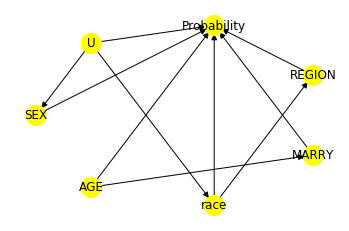

In [7]:
# With graph
model=CausalModel(
        data = df,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [8]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                           
───────(Expectation(Probability|MARRY,AGE,SEX))
d[race]                                        
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,MARRY,AGE,SEX,U) = P(Probability|race,MARRY,AGE,SEX)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [9]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                           
───────(Expectation(Probability|MARRY,AGE,SEX))
d[race]                                        
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,MARRY,AGE,SEX,U) = P(Probability|race,MARRY,AGE,SEX)

## Realized estimand
b: Probability~race+MARRY+AGE+SEX
Target units: ate

## Estimate
Mean value: 0.03233060504839807

Causal Estimate is 0.03233060504839807


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [10]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.03233060504839807
New effect:0.036878501137865116



# Replace Treatment with Placebo

In [11]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.03233060504839807
New effect:-7.8775613171272e-05
p value:0.45999999999999996



# Remove Random Subset of Data

In [12]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.03233060504839807
New effect:0.03504297947905155
p value:0.14

